# Comparison zfp vs sz and model

Comparing compression factors.

In [14]:
import numpy as np
import time
import xarray as xr
import pickle
import subprocess
import os
import zfpy
import matplotlib.pyplot as plt
from lossycomp.compress import compress
from lossycomp.decompress import decompress
from lossycomp.constants import data_path
from lossycomp.plots import single_plot
from lossycomp.encodings import encode_lat, encode_lon

In [15]:
with open('../results/output/CF_sz_zfp_model_final.pkl', 'rb') as f:
    data = pickle.load(f)

In [16]:
cf_model = []
cf_sz = []
cf_zfp = []

std_model = []
std_sz = []
std_zfp= []

std_model = []
std_sz = []
std_zfp = []

time_model = []
time_sz = []
time_zfp = []

for i in [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1.0]:
    cf_model.append(np.mean(data['model_1']['cf_' + str(i)]))
    cf_sz.append(np.mean(data['sz']['cf_' + str(i)]))
    cf_zfp.append(np.mean(data['zfp']['cf_' + str(i)]))
    std_model.append(np.std(data['model_1']['cf_' + str(i)]))
    std_sz.append(np.std(data['sz']['cf_' + str(i)]))
    std_zfp.append(np.std(data['zfp']['cf_' + str(i)]))
    
    time_model.append(np.mean(data['model_1']['time_' + str(i)]))
    time_sz.append(np.mean(data['sz']['time_' + str(i)]))
    time_zfp.append(np.mean(data['zfp']['time_' + str(i)]))
    

<ipython-input-17-386e33caf3f5>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


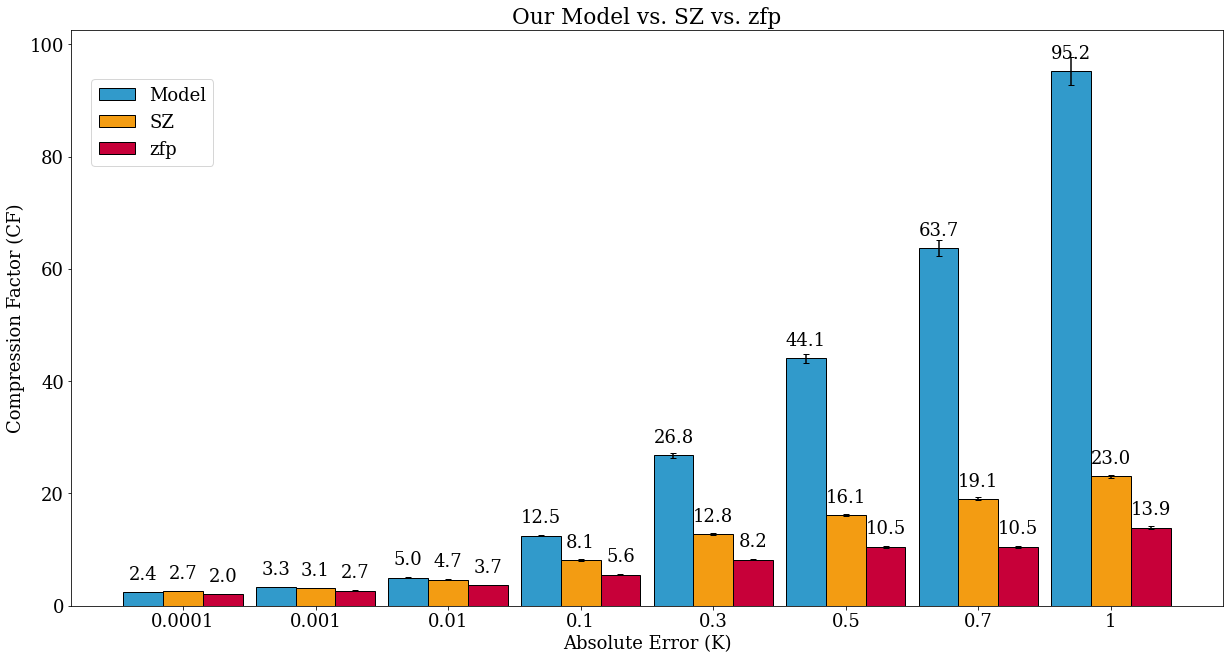

In [17]:
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(16,8))
cf = np.arange(8)
ax = fig.add_axes([0,0,1,1])
pps = ax.bar(cf - 0.30, cf_model, width = 0.30, yerr= std_model, label = 'Model', color = '#319ACB',  capsize = 3,
       edgecolor = 'k')
pps1= ax.bar(cf + 0.00, cf_sz, width = 0.30, yerr= std_sz,label = 'SZ', color = '#F39C12', capsize = 3,
       edgecolor = 'k')
pps2 = ax.bar(cf + 0.30, cf_zfp, width = 0.30, yerr= std_zfp, label = 'zfp', color = '#C70039', capsize = 3,
       edgecolor = 'k')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1:8] = ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1']
width = 0.30
for p in pps:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height+1),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
    
for p in pps1:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height+1),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom') 
    
for p in pps2:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height+1),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
ax.set_xticklabels(labels)
fig.legend(bbox_to_anchor=(0.01, 1.03, 1, -0.1), loc=2,
           ncol=1)
#plt.grid()
plt.xlabel('Absolute Error (K)')
plt.ylabel('Compression Factor (CF)')
plt.title('Our Model vs. SZ vs. zfp')
plt.savefig('CF_sz_model_zfp.png' ,dpi=300,bbox_inches='tight')

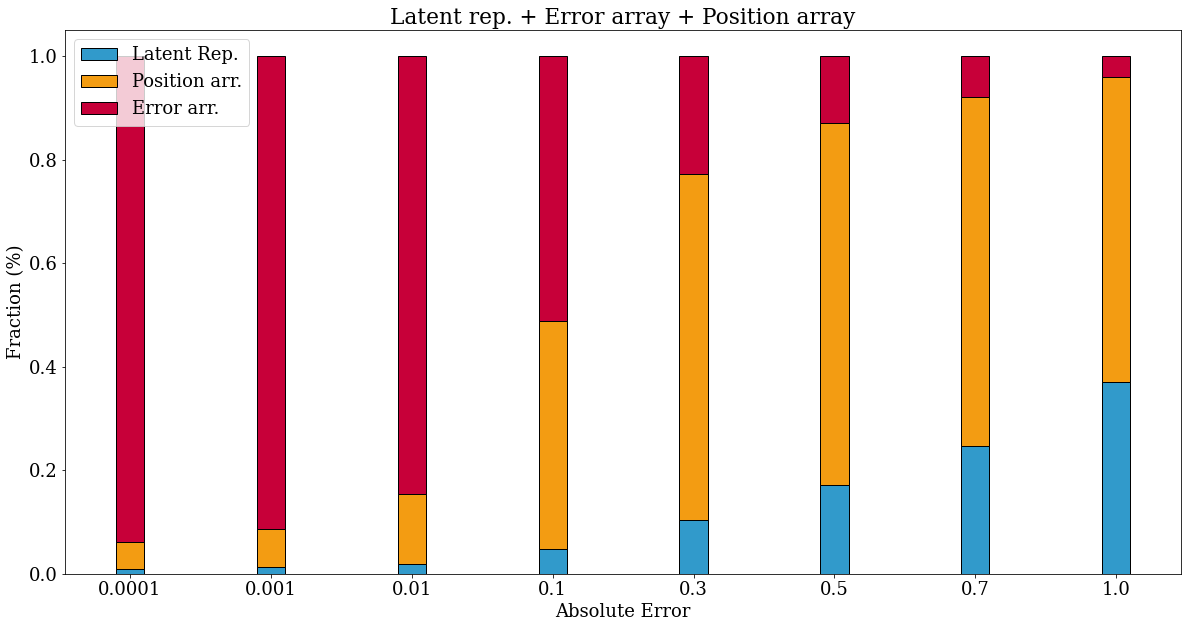

In [18]:
latent_space = []
error_space = []
mask_space = []


for i in [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1.0]:
    latent_space.append(np.mean(data['model_1']['latent_' + str(i)]))
    error_space.append(np.mean(data['model_1']['mask_' + str(i)]))
    mask_space.append(np.mean(data['model_1']['error_' + str(i)]))

width = 0.20# the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))


ax.bar( ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1.0'], latent_space, width,  label='Latent Rep.',color = '#319ACB',  edgecolor = 'k')
ax.bar( ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1.0'], mask_space, width,  bottom = latent_space, color = '#F39C12',  edgecolor = 'k',
       label='Position arr.')
ax.bar( ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1.0'], error_space, width, color = '#C70039',  edgecolor = 'k', label='Error arr.', bottom =np.array(latent_space)+np.array(mask_space))


ax.set_ylabel('Fraction (%)')
ax.set_xlabel('Absolute Error')
ax.set_title('Latent rep. + Error array + Position array')
ax.legend()
plt.savefig('model_space.png' ,dpi=300,bbox_inches='tight')

# Testing Compression

In [19]:
data_or = xr.open_mfdataset(data_path + '/data/ECMWF/1980/*/temperature.nc', combine='by_coords')
data_or = data_or.sel(time=slice('1980-12-1T00:00:00','1980-12-3T1:00:00'), level = slice(985,1000), longitude = slice(-100,-40), latitude = slice(30,-30))
data_or = data_or.transpose('time', 'latitude', 'longitude', 'level')
data_or

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 1, longitude: 241, time: 50)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 30.0 29.75 29.5 29.25 ... -29.5 -29.75 -30.0
  * level      (level) int32 1000
  * time       (time) datetime64[ns] 1980-12-01 ... 1980-12-03T01:00:00
Data variables:
    t          (time, latitude, longitude, level) float32 dask.array<chunksize=(50, 241, 241, 1), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-07-08 13:03:33 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [20]:
extra = False
soil = True
if extra:
    # In case we use the extra information:
    lat = data_or['t'].coords['latitude'].values
    lon = data_or['t'].coords['longitude'].values

    lat_st = np.stack([encode_lat(x) for x in lat])
    lon_st = np.stack([encode_lon(x) for x in lon])

    lat1, lat2 = np.hsplit(lat_st, 2)
    lon1, lon2 = np.hsplit(lon_st, 2)

    xx, yy = np.meshgrid(lon1, lat1)
    xx2, yy2 = np.meshgrid(lon2, lat2)

    coords_lat = np.concatenate([[xx]] * len(data_or.time), axis=0)
    coords_lon = np.concatenate([[yy]] * len(data_or.time), axis=0)
    coords_lat1 = np.concatenate([[xx2]] * len(data_or.time), axis=0)
    coords_lon1 = np.concatenate([[yy2]] * len(data_or.time), axis=0)

    coords_lat = np.expand_dims(coords_lat, axis=3)
    coords_lon = np.expand_dims(coords_lon, axis=3)

    coords_lat1 = np.expand_dims(coords_lat1, axis=3)
    coords_lon1 = np.expand_dims(coords_lon1, axis=3)

    temp = data_or['t'].values
    data_or =  np.concatenate((temp, coords_lat, coords_lon, coords_lat1, coords_lon1 ),axis = 3)

    data_or.shape
    # 402.84 MB
if soil:
    data_soil = xr.open_mfdataset(data_path + 'data/ECMWF/1980_single/*/land-sea-mask.nc', combine='by_coords')
    data_soil = data_soil.sel(time=slice('1980-12-1T00:00:00','1980-12-3T1:00:00'),longitude = slice(-100,-40), latitude = slice(30,-30))
    data_soil = data_soil.transpose('time', 'latitude', 'longitude')
    data_soil = data_soil['lsm']
    data_soil = np.expand_dims(data_soil.values, axis=3)
    data_or =  np.concatenate((data_or['t'].values, data_soil ),axis = 3)

if not (soil or extra):
    data_or = data_or['t']
    data_or = data_or.values


## Original Data

(1, 50, 241, 241, 1)


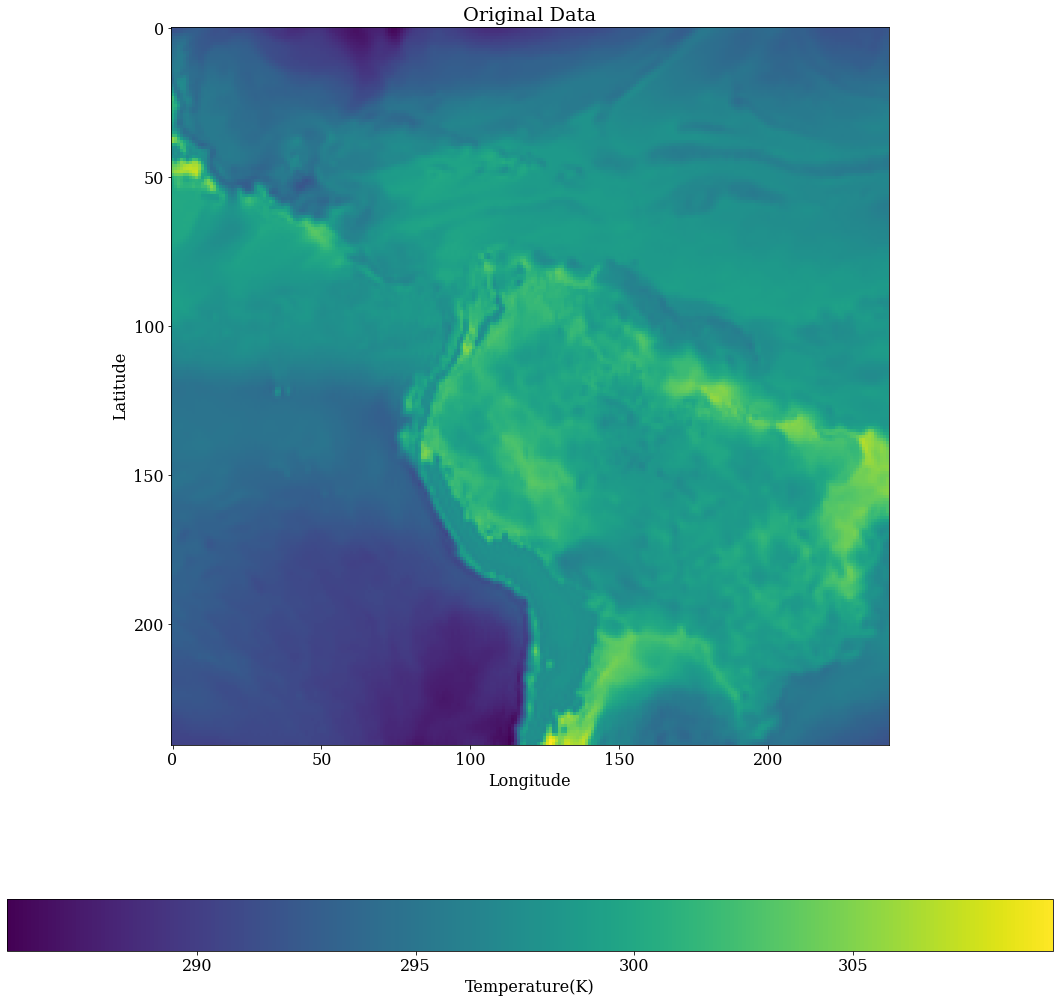

In [21]:
data_r = np.expand_dims(data_or[:,:,:,0], axis=0)
#data_r = np.expand_dims(data_or, axis=0)
data_r = np.expand_dims(data_r, axis=4)
print(data_r.shape)
plt.rcParams.update({'font.size': 16})
single_plot(data_r, 0, "Original Data", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

In [22]:
abs_error = 1
abs_error_zfp = 1
abs_error_sz =  1

## Model

In [24]:
compressed_data = compress(data_or, abs_error)
decompressed_data = decompress(compressed_data)
CF_model = data_or[:,:,:,0].nbytes / len(compressed_data) 
print('CF:', CF_model)

CF: 63.688798728000435


In [25]:
def psnr(y,x):
    vrange = np.max(y) - np.min(y)
    mse = (np.mean((y-x)*(y-x)))
    psnr = 20 * np.log10(vrange )- 10 * np.log10(mse)
    return psnr

psnr_model = psnr(data_or[0,:,:,0],decompressed_data[0,:,:,0])
error_model = np.max(data_or[:,:,:,:]-decompressed_data[:,:,:,:])
print('PSNR', psnr_model)
print('Max error Model:',  np.round(error_model,4))

PSNR 36.42376184463501
Max error Model: 1.0


(1, 50, 241, 241, 1)


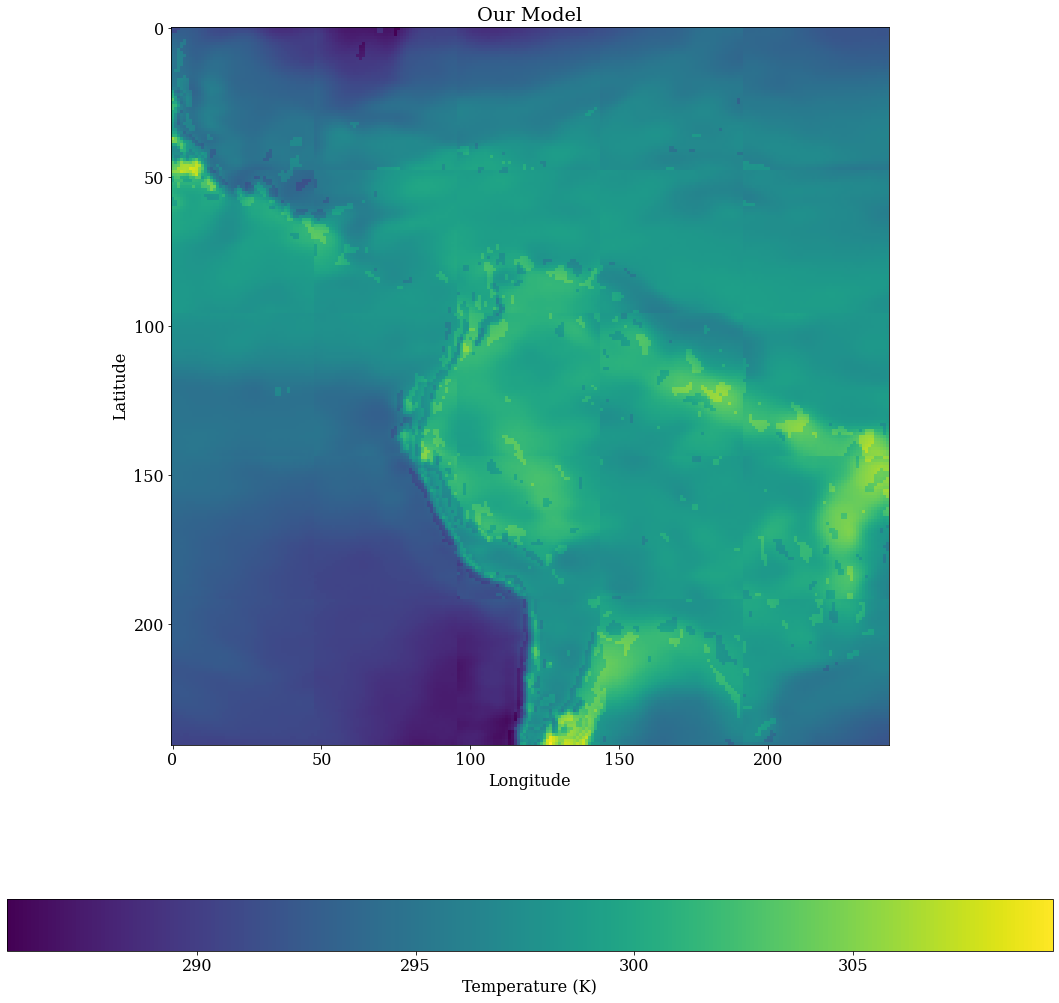

In [26]:
decom = np.expand_dims(decompressed_data, axis=0)
print(decom.shape)
single_plot(decom, 0, "Our Model", "Temperature (K)", data_r[0,0].min(), data_r[0,0].max())

# ZFP

In [27]:
compressed_data = zfpy.compress_numpy(data_or[:,:,:,0],  tolerance=abs_error_zfp)
decompressed_array = zfpy.decompress_numpy(compressed_data)
print('CF: ', data_or[:,:,:,0].nbytes / len(compressed_data) )
CF_zfp=data_or[:,:,:,0].nbytes / len(compressed_data) 

CF:  11.629876735040407


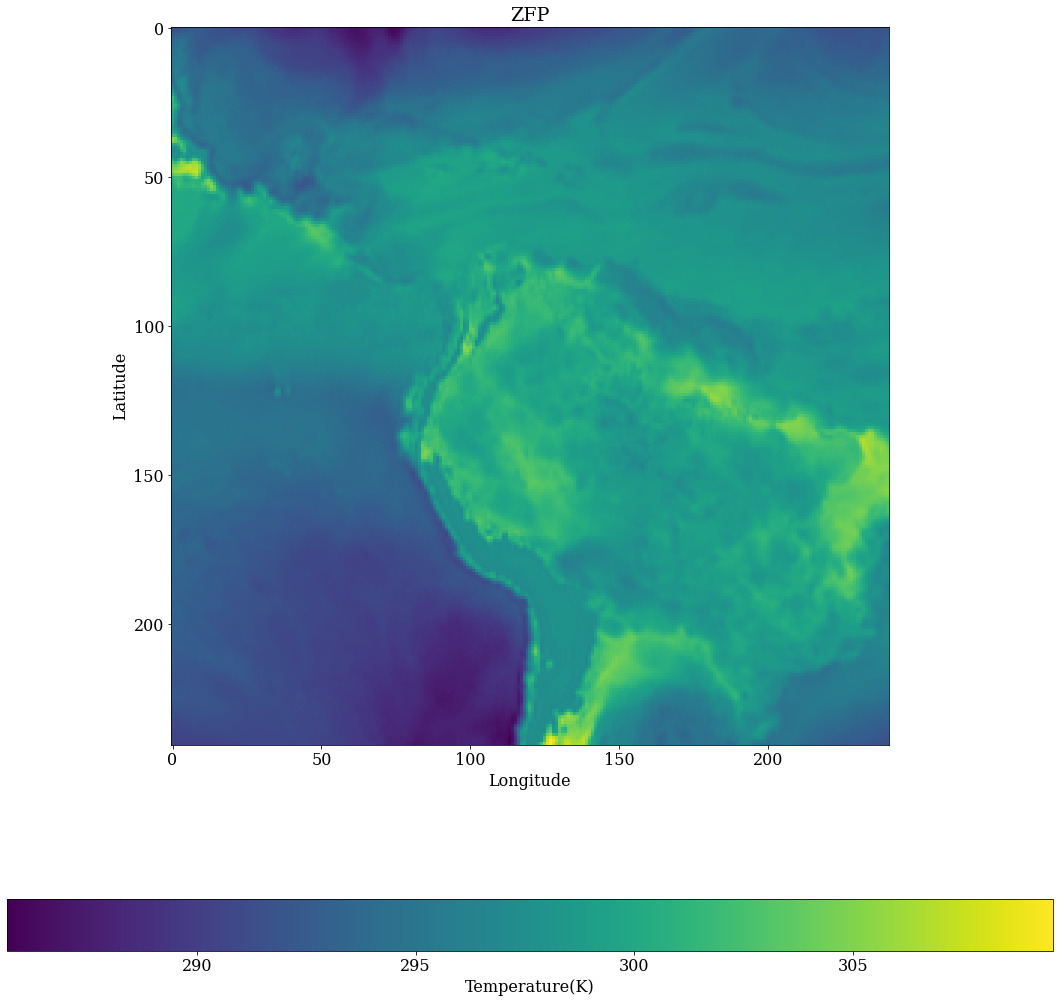

In [28]:
data_zfp = np.expand_dims(decompressed_array, axis=0)
data_zfp = np.expand_dims(data_zfp, axis=4)
single_plot(data_zfp, 0, "ZFP", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

In [29]:
psnr_zfp = psnr(data_or[0,:,:,0], decompressed_array[0,:,:])
print('PSNR', psnr_zfp)
error_zfp = np.max(data_or[:,:,:,0]-decompressed_array[:,:,:])
print('Max error ZFP:', np.max(data_or[:,:,:,0]-decompressed_array[:,:,:]))
#np.testing.assert_allclose(data_or[:,:,:,0], decompressed_array, atol=abs_error)

PSNR 56.44010305404663
Max error ZFP: 0.24768066



Data Original
Mean: 296.38162
Standard Dev.: 3.6193936
Max Val: 314.016
Min Val: 281.02322

Decompressed
Mean: 296.37897
Standard Dev.: 3.6196136
Max Val: 313.95312
Min Val: 280.99658

Error
Mean: 0.0026132294
Standard Dev.: 0.03572237
Max error: 0.24768066
Min error: -0.1791687



Text(0, 0.5, 'Count')

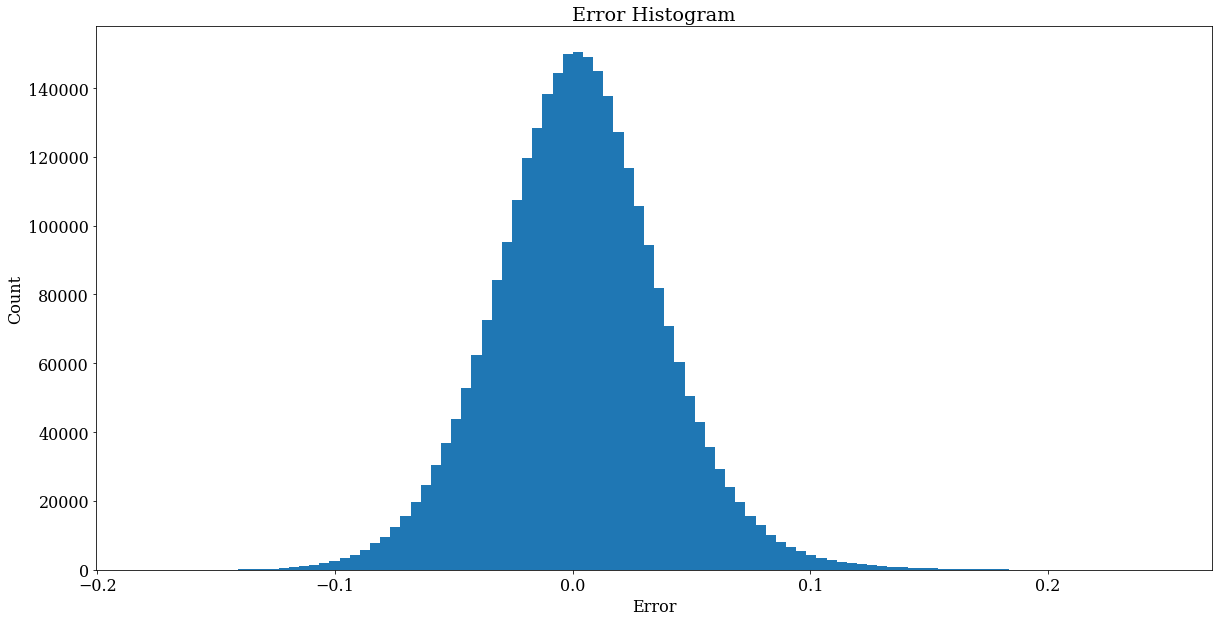

In [30]:
original = data_r
diff = (data_r[0,:,:,:,0]-decompressed_array)

print("")
print("Data Original")
print("=======")
print("Mean:", original.mean())
print("Standard Dev.:", original.std())
print("Max Val:", original.max())
print("Min Val:", original.min())
print("")
print("Decompressed")
print("=======")
print("Mean:", decompressed_array.mean())
print("Standard Dev.:", decompressed_array.std())
print("Max Val:", decompressed_array.max())
print("Min Val:", decompressed_array.min())
print("")
print("Error")
print("=======")
print("Mean:", diff.mean())
print("Standard Dev.:", diff.std())
print("Max error:", diff.max())
print("Min error:", diff.min())
print("")


plt.figure(figsize=(20,10))
plt.hist(diff.flatten(),100)
plt.title('Error Histogram')
plt.xlabel('Error')
plt.ylabel('Count')

# SZ

In [31]:

filename = 'zexact.dat'
data_or[:,:,:,0].tofile(filename)

subprocess.run(['../../SZ/build/bin/sz', '-z', '-f','-M', 'ABS', '-A', str(abs_error_sz),'-i',  filename, '-3', '50','241' ,'241'], 
               stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

subprocess.run(['../../SZ/build/bin/sz', '-x', '-f', '-s', filename + '.sz', '-3',  '50','241' ,'241'],
               stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

z_sz = np.fromfile(filename + '.sz.out', dtype= np.float32)
z_sz = z_sz.reshape(data_or[:,:,:,0].shape)


print('SZ',  data_or[:,:,:,0].nbytes/os.path.getsize(filename + '.sz'))
CF_SZ = data_or[:,:,:,0].nbytes/os.path.getsize(filename + '.sz')

# Cleanup
os.remove(filename)
os.remove(filename + '.sz')
os.remove(filename + '.sz.out')



SZ 18.153460990890608


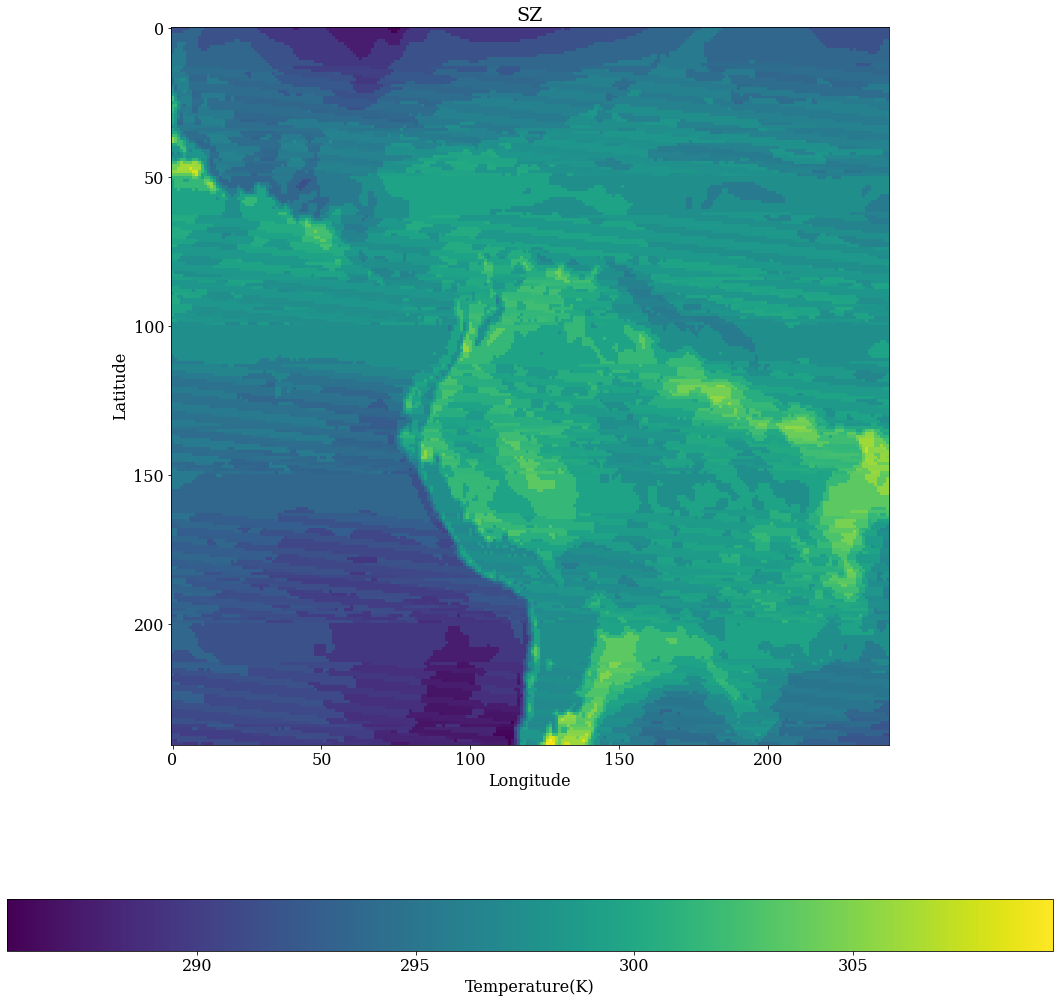

In [32]:
data_sz = np.expand_dims(z_sz, axis=0)
data_sz = np.expand_dims(data_sz, axis=4)
single_plot(data_sz, 0, "SZ", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

In [33]:
psnr_SZ = psnr(data_or[0,:,:,0], z_sz[0,:,:])
print('PSNR', psnr_SZ)
error_SZ =  np.max(data_or[:,:,:,0]-z_sz)
print('Max error SZ:', np.max(data_or[:,:,:,0]-z_sz))

PSNR 32.358552515506744
Max error SZ: 1.0



Data Original
Mean: 296.38162
Standard Dev.: 3.6193936
Max Val: 314.016
Min Val: 281.02322

Decompressed
Mean: 296.38177
Standard Dev.: 3.6663654
Max Val: 314.4091
Min Val: 280.74927

Error
Mean: -4.5822835e-05
Standard Dev.: 0.57742065
Max error: 1.0
Min error: -1.0



Text(0, 0.5, 'Count')

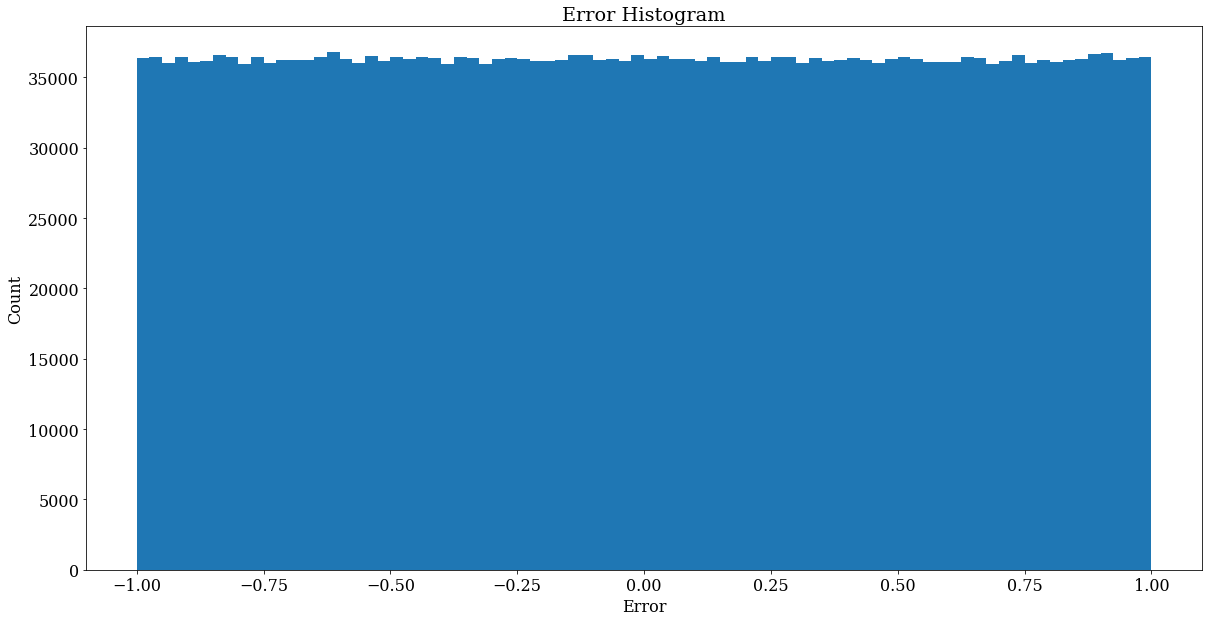

In [34]:
original = data_r
diff = (data_r[0,:,:,:,0]-z_sz)

print("")
print("Data Original")
print("=======")
print("Mean:", original.mean())
print("Standard Dev.:", original.std())
print("Max Val:", original.max())
print("Min Val:", original.min())
print("")
print("Decompressed")
print("=======")
print("Mean:", z_sz.mean())
print("Standard Dev.:", z_sz.std())
print("Max Val:", z_sz.max())
print("Min Val:", z_sz.min())
print("")
print("Error")
print("=======")
print("Mean:", diff.mean())
print("Standard Dev.:", diff.std())
print("Max error:", diff.max())
print("Min error:", diff.min())
print("")


plt.figure(figsize=(20,10))
plt.hist(diff.flatten(),80)
plt.title('Error Histogram')
plt.xlabel('Error')
plt.ylabel('Count')

# Visualization of the decompressed data

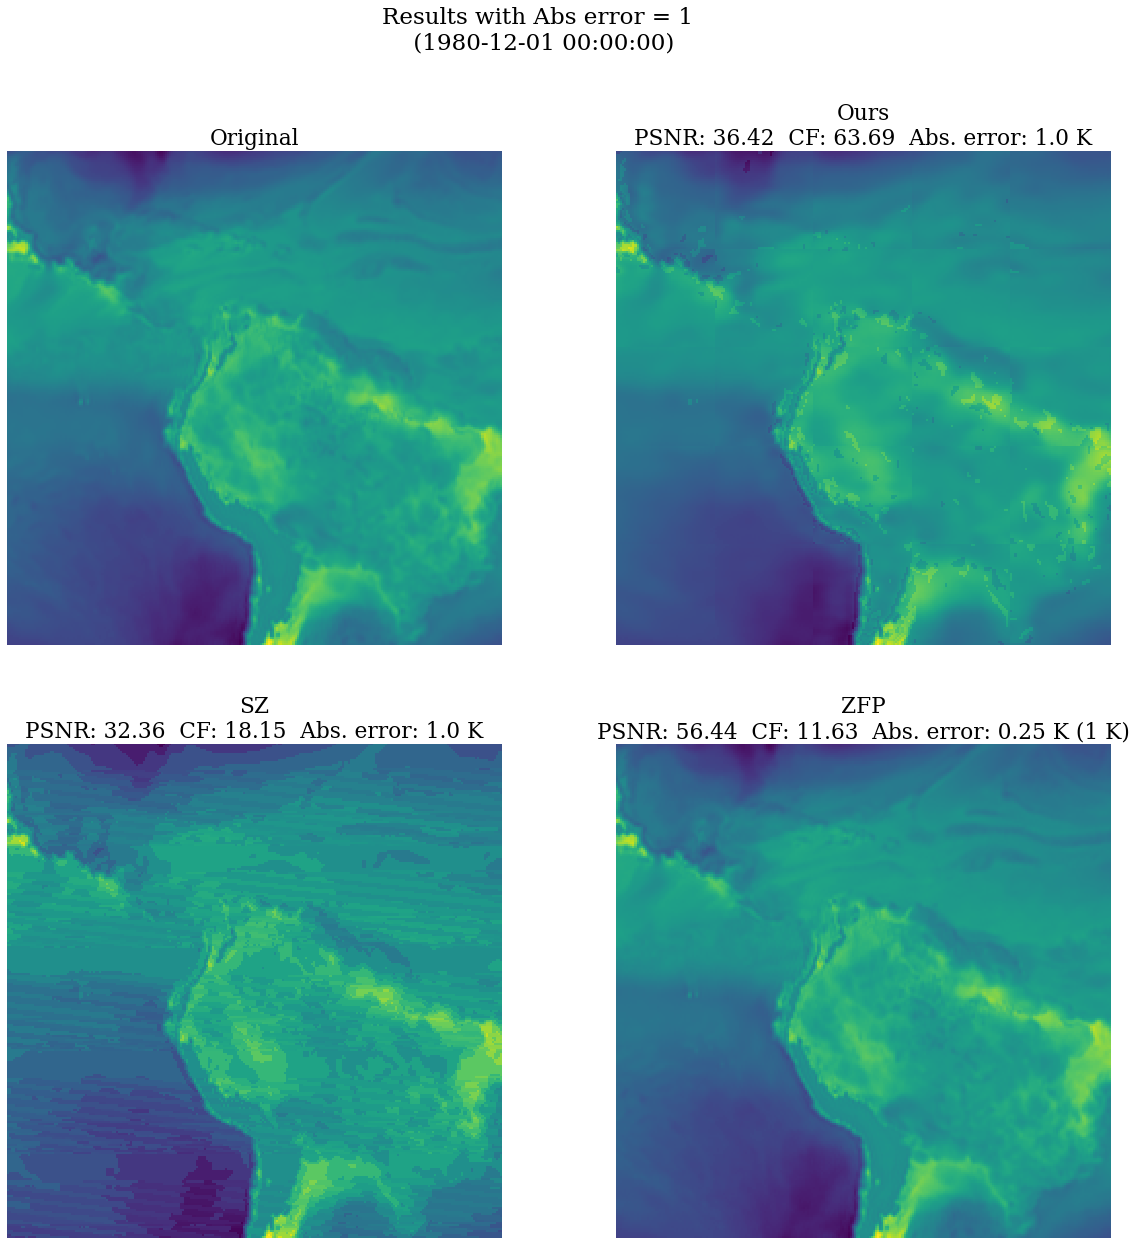

In [35]:
import matplotlib
fig, ax = plt.subplots(2, 2, figsize=(20,20), sharex=True,sharey=True)
matplotlib.rcParams.update({'font.size': 18})
min_val = data_r[0,0,:,:,0].min()
max_val = data_r[0,0,:,:,0].max()
im = ax[0,0].imshow(data_r[0,0,:,:,0], vmin=min_val, vmax=max_val, interpolation='none', cmap='viridis')
ax[0,1].imshow(decom[0,0,:,:,0], vmin=min_val, vmax=max_val, interpolation='none', cmap='viridis')
ax[1,0].imshow(data_sz[0,0,:,:,0], vmin=min_val, vmax=max_val, interpolation='none', cmap='viridis')
ax[1,1].imshow(data_zfp[0,0,:,:,0], vmin=min_val, vmax=max_val, interpolation='none', cmap='viridis')

title_model = 'Ours\nPSNR: '+ str(round(psnr_model,2)) + '  CF: ' + str(round(CF_model,2)) + '  Abs. error: '+ str(round(error_model,2)) +' K'
title_SZ = 'SZ\nPSNR: '+ str(round(psnr_SZ,2)) + '  CF: ' + str(round(CF_SZ,2))+ '  Abs. error: '+ str(round(error_SZ,2)) + ' K'
title_zfp = 'ZFP\nPSNR: '+ str(round(psnr_zfp,2)) + '  CF: ' + str(round(CF_zfp,2)) + '  Abs. error: '+ str(round(error_zfp,2)) +' K (' + str(abs_error_zfp)+' K)'

ax[0,0].set_title('Original')
ax[0,1].set_title(title_model)
ax[1,0].set_title(title_SZ)
ax[1,1].set_title(title_zfp)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

#fig.text(0.5, 0.04, 'Longitude', ha='center')
#fig.text(0.04, 0.5, 'Latitude', va='center', rotation='vertical')
fig.suptitle('Results with Abs error = 1 \n (1980-12-01 00:00:00)', fontsize=23)
plt.savefig('CF_results.png')